# Muultiwavelength HDF5 input
Added by Shooby: Oct 24th 2019, Last edited Oct 30, 2020

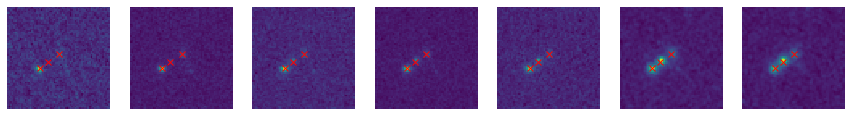

In [6]:
from galblend import *
im, data = galblend(gals=3, lim_hmag=25, plot_it=True)


In [49]:
hi_psfs = ['psf_b.fits','psf_v.fits', 'psf_i.fits','psf_i.fits', 'psf_z.fits', 'psf_j.fits', 'psf_h.fits']
lo_psfs = ['PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits',
           'PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits']

kernel = np.zeros((41,41,1,7))
for i in range(len(hi_psfs)):
    psf = pyfits.getdata('../psfs/'+hi_psfs[i])
    psf = downscale_local_mean(psf,(3,3))
    psf = psf[7:-8,7:-8]

    psf_hsc = pyfits.getdata('../psfs/'+lo_psfs[i])
    psf_hsc = psf_hsc[1:42,1:42]    
    kern = create_matching_kernel(psf,psf_hsc)
    psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
    kernel[:,:,:,i] = psfh


kernel = torch.Tensor(kernel)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()


In [114]:
import h5py

hf = h5py.File('Sample_train.hdf5', 'r')
hf.keys()
nc = 7
boz=np.random.randint(1,100)
mm = hf['train_img'][boz, ...]

device = torch.device("cpu")

mm = np.zeros((1,7,64,64))
mm[0,...] = hf['train_img'][boz, ...]

real_cpu = torch.Tensor(mm).float()
im = real_cpu+0.25*torch.rand_like(real_cpu)
        
kernel = kernel.to(device)
img2 = torch.tensor(np.zeros((1,nc,22,22)))

for ch in range(real_cpu.shape[1]):
    imagetoconvolv = real_cpu[:,ch,:,:].reshape(-1,1,64,64)
    kerneltoconvolv = kernel[:,ch,:,:].reshape(-1,1,41,41)
            
    downsampled = F.upsample(imagetoconvolv,scale_factor=1/3,mode='bilinear')
    img2[:,ch,:-1,:-1] = F.conv2d(downsampled, kerneltoconvolv,padding=int(((kernel.shape[3])-1)/2))       
    img2[:,ch,-1,:] = np.median(img2[:,ch,:-1,:-1])
    img2[:,ch,:,-1] = np.median(img2[:,ch,:-1,:-1])
    

img = img2.view(-1,nc,22,22)
img = img[:,:,:,:].float()#.cuda()        

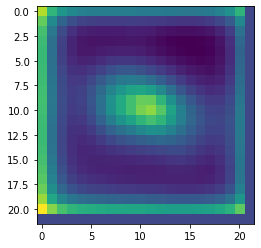

In [115]:
plt.imshow(img[0,6,:,:])

In [4]:
#%rm 'Sample.hdf5'
import torchvision.transforms as transforms
from galblend import *
import h5py

sample_size = 5000

tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_shape = (sample_size, 7, 64, 64)

hdf5_file = h5py.File('Sample_train.hdf5', mode='w')
hdf5_file.create_dataset("train_img", train_shape, np.float32)
#hdf5_file.create_dataset("train_labels", (sample_size,), np.float32)
#hdf5_file["train_labels"][...] = redshift

for i in range(sample_size):
    # print how many images are saved every 1000 images
    if i % 500 == 0 and i > 1:
        print ('Train data: {}/{}'.format(i, sample_size))
    im, data = galblend(gals=2, lim_hmag=25, plot_it=False)
    pashe = np.zeros((7,64,64))

    for chi in range(7):
        s = ndimage.rotate(im[chi,:,:],0,mode='nearest',reshape=False)
        da = np.arcsinh(s)
        pash = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        pashe[chi,:,:] = tfms(pash)

    # save the image and calculate the mean so far
    hdf5_file["train_img"][i, ...] = pashe

hdf5_file.close()

Train data: 500/5000
Train data: 1000/5000
Train data: 1500/5000
Train data: 2000/5000
Train data: 2500/5000
Train data: 3000/5000
Train data: 3500/5000
Train data: 4000/5000
Train data: 4500/5000


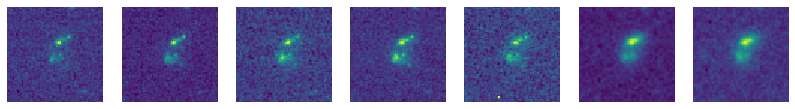

In [5]:
hf = h5py.File('Sample_train.hdf5', 'r')
hf.keys()

boz=np.random.randint(1,100)
mm = hf['train_img'][boz, ...]
plt.figure(figsize=(14,3))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(mm[i,:,:],origin='lower')
    plt.axis('off')
hf.close()

In [ ]:
gs = pyfits.getdata('/Users/shemmati/Dropbox/WFIRST_WPS/CANDELS_fits/gds.fits')
sel = (gs['zbest']>0.01)&(gs['zbest']<4.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.)&(gs['ISOAREA_IMAGE_F160W']>=40)&(gs['DECdeg']>-27.87)

sample_size = len(gs[sel])
image_size = 64
cut_size = 32
ra1,dec1,red1 = gs['RA_1'][sel],gs['DEC_1'][sel],gs['zbest'][sel]
mass1,sfr1 = gs['M_neb_med_lin'][sel], gs['SFR_13a_tau'][sel]
urest1,vrest1,jrest1 = gs['restUXbessel'][sel],gs['restVbessel'][sel],gs['restJpalomar'][sel]

# furthur cut on brightest galaxy being at the center of the cutout
redshift,ra,dec,mass,sfr,urest,vrest,jrest = [],[],[],[],[],[],[],[]
for i in range(sample_size):
    dat = cut(ra1[i],dec1[i],cut_size,imdir+'goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    if (brightest_center(dat)):
        redshift.append(red1[i])
        ra.append(ra1[i])
        dec.append(dec1[i])
        mass.append(mass1[i])
        sfr.append(sfr1[i])
        urest.append(urest1[i])
        vrest.append(vrest1[i])
        jrest.append(jrest1[i])

sample_size = len(redshift)
print (sample_size)

In [ ]:
gs = pyfits.getdata('/Users/shemmati/Dropbox/WFIRST_WPS/CANDELS_fits/gds.fits')
sel = (gs['zbest']>0.01)&(gs['zbest']<2.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.)&(gs['ISOAREA_IMAGE_F160W']>=25)&(gs['DECdeg']<-27.87)

sample_size = len(gs[sel])
image_size = 64
cut_size = 32
ra1,dec1,red1 = gs['RA_1'][sel],gs['DEC_1'][sel],gs['zbest'][sel]
mass1,sfr1 = gs['M_neb_med_lin'][sel], gs['SFR_13a_tau'][sel]
urest1,vrest1,jrest1 = gs['restUXbessel'][sel],gs['restVbessel'][sel],gs['restJpalomar'][sel]

# furthur cut on brightest galaxy being at the center of the cutout
redshift,ra,dec,mass,sfr,urest,vrest,jrest = [],[],[],[],[],[],[],[]
for i in range(sample_size):
    dat = cut(ra1[i],dec1[i],cut_size,imdir+'goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    if (brightest_center(dat)):
        redshift.append(red1[i])
        ra.append(ra1[i])
        dec.append(dec1[i])
        mass.append(mass1[i])
        sfr.append(sfr1[i])
        urest.append(urest1[i])
        vrest.append(vrest1[i])
        jrest.append(jrest1[i])

sample_size = len(redshift)
print (sample_size)

In [ ]:
#%rm 'Sample.hdf5'
import torchvision.transforms as transforms
tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

train_shape = (sample_size, 7, 64, 64)

hdf5_file = h5py.File('Sample_test.hdf5', mode='w')

hdf5_file.create_dataset("test_img", train_shape, np.float32)
hdf5_file.create_dataset("test_labels", (sample_size,), np.float32)
hdf5_file["test_labels"][...] = redshift

for i in range(sample_size):
    # print how many images are saved every 1000 images
    if i % 500 == 0 and i > 1:
        print ('Test data: {}/{}'.format(i, len(gs[sel])))

        
    data = np.zeros((7,64,64))
    pashe = np.zeros((7,64,64))
    
    data[0,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits')
    data[1,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    data[2,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
    data[3,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    data[4,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    data[5,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f125w_060mas_v1.0_drz.fits')
    data[6,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')

    for chi in range(7):
        s = ndimage.rotate(data[chi,:,:],0,mode='nearest',reshape=False)
        da = np.arcsinh(s)
        pash = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        pashe[chi,:,:] = tfms(pash)

    # save the image and calculate the mean so far
    hdf5_file["test_img"][i, ...] = pashe

hdf5_file.close()

In [ ]:
import torch
from galaxy_hdf5loader import galaxydata

dataset = galaxydata('Sample_train.hdf5')
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=True, num_workers=int(0))

inputs, classes = next(iter(dataloader))  
real_cpu = inputs.to('cpu')
ajab = real_cpu.detach()
ajab = ajab.cpu()

In [ ]:
plt.figure(figsize=(14,3))
for i in range(7):
    plt.subplot(1,7,i+1) 
    plt.imshow(ajab[0,i,:,:],origin='lower')
    plt.axis('off')
